In [587]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [297]:
# Check for missing values
awards_players = pd.read_csv('awards_players.csv')
coaches = pd.read_csv('coaches.csv')
players = pd.read_csv('players.csv')
players_teams = pd.read_csv('players_teams.csv')
series_post = pd.read_csv('series_post.csv')
teams = pd.read_csv('teams.csv')
teams_post = pd.read_csv('teams_post.csv')

In [299]:
# 1. Physical Attributes
players['bmi'] = (players['weight'] * 0.453592) / ((players['height'] * 0.0254) ** 2)
players['height_category'] = pd.cut(players['height'], bins=[0, 70, 76, 90], labels=['Short', 'Average', 'Tall'])

# 4. Position Grouping
def map_position_group(pos):
    if pd.isna(pos):
        return 'Unknown'
    pos = pos.split("-")[0]  # Handle hybrid positions like "F-C"
    if pos in ['C', 'F-C']:
        return 'Frontcourt'
    elif pos in ['F', 'G-F']:
        return 'Frontcourt'
    elif pos in ['G', 'G-C']:
        return 'Backcourt'
    else:
        return 'Unknown'

players['position_group'] = players['pos'].apply(map_position_group)

# Drop unnecessary columns only after all calculations are done
players.drop(['weight', 'firstseason', 'lastseason', 'pos','deathDate'], axis=1, inplace=True)


In [301]:
# Assuming the uploaded CSV is already loaded into a dataframe named `teams`
# 1. Win Ratios
teams['win_ratio'] = teams['won'] / teams['GP']
teams.drop(['won'], axis=1, inplace=True)

teams['home_win_ratio'] = teams['homeW'] / (teams['homeW'] + teams['homeL'])
teams.drop(['homeW', 'homeL'], axis=1, inplace=True)

teams['away_win_ratio'] = teams['awayW'] / (teams['awayW'] + teams['awayL'])
teams.drop(['awayW', 'awayL'], axis=1, inplace=True)

teams['conf_win_ratio'] = teams['confW'] / (teams['confW'] + teams['confL'])
teams.drop(['confW', 'confL'], axis=1, inplace=True)

# 2. Scoring Efficiency
teams['off_efficiency'] = teams['o_pts'] / (teams['o_fga'] + teams['o_fta'])
teams.drop(['o_pts', 'o_fga', 'o_fta'], axis=1, inplace=True)

teams['def_efficiency'] = teams['d_pts'] / (teams['d_fga'] + teams['d_fta'])
teams.drop(['d_pts', 'd_fga', 'd_fta'], axis=1, inplace=True)

# 3. Rebounding Metrics
teams['off_reb_percentage'] = teams['o_oreb'] / (teams['o_oreb'] + teams['d_dreb'])
teams.drop(['o_oreb', 'd_dreb'], axis=1, inplace=True)

teams['def_reb_percentage'] = teams['o_dreb'] / (teams['o_dreb'] + teams['d_oreb'])
teams.drop(['o_dreb', 'd_oreb'], axis=1, inplace=True)

# 4. Turnover Ratio
teams['to_ratio'] = teams['o_to'] / teams['GP']

# Assuming the dataframe is named `teams`

# 1. Scoring Contribution
teams['fgm_contribution'] = teams['o_fgm'] * 2 + teams['o_3pm'] * 3
teams['ftm_contribution'] = teams['o_ftm']  # Free throws worth 1 point each
teams['three_point_ratio'] = teams['o_3pm'] / teams['o_3pa']

# Drop the columns used above
teams.drop(['o_fgm', 'o_3pm', 'o_ftm', 'o_3pa'], axis=1, inplace=True)

# 2. Rebounding Contribution
teams['off_reb_contribution'] = teams['tmORB'] / (teams['tmORB'] + teams['opptmDRB'])
teams['def_reb_contribution'] = teams['tmDRB'] / (teams['tmDRB'] + teams['opptmORB'])
teams['total_reb_contribution'] = teams['tmTRB'] / (teams['tmTRB'] + teams['opptmTRB'])

# Drop rebounding columns
teams.drop(['tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'], axis=1, inplace=True)

# 3. Assist-to-Turnover Ratios
teams['off_ast_to_ratio'] = teams['o_asts'] / teams['o_to']
teams['def_ast_to_ratio'] = teams['d_asts'] / teams['d_to']

# Drop assist and turnover columns
teams.drop(['o_asts', 'd_asts', 'o_to', 'd_to'], axis=1, inplace=True)

# 4. Steal and Block Ratios
teams['off_steal_ratio'] = teams['o_stl'] / teams['GP']
teams['off_block_ratio'] = teams['o_blk'] / teams['GP']
teams['def_steal_ratio'] = teams['d_stl'] / teams['GP']
teams['def_block_ratio'] = teams['d_blk'] / teams['GP']

# Drop the corresponding columns
teams.drop(['o_stl', 'o_blk', 'd_stl', 'd_blk'], axis=1, inplace=True)

# 5. Efficiency per Minute
teams['efficiency_per_min'] = (teams['win_ratio'] + teams['off_efficiency'] - teams['def_efficiency']) / teams['min']

# Drop the `min` column as it's been used
teams.drop(['min'], axis=1, inplace=True)

# 6. Points allowed vs. Points scored
teams['points_diff'] = (teams['win_ratio'] * teams['GP'] * teams['off_efficiency']) - (teams['def_efficiency'] * teams['GP'] * teams['win_ratio'])

# Drop any other residual columns
teams.drop(['d_fgm', 'd_ftm', 'd_3pm', 'd_3pa', 'o_reb', 'd_reb', 'o_pf', 'd_pf', 'lost'], axis=1, inplace=True)


In [411]:
teams.head()

,year,lgID,tmID,franchID,confID,divID,rank,playoff,seeded,firstRound,semis,finals,name,GP,attend,arena,win_ratio,home_win_ratio,away_win_ratio,conf_win_ratio,off_efficiency,def_efficiency,off_reb_percentage,def_reb_percentage,to_ratio,fgm_contribution,ftm_contribution,three_point_ratio,off_reb_contribution,def_reb_contribution,total_reb_contribution,off_ast_to_ratio,def_ast_to_ratio,off_steal_ratio,off_block_ratio,def_steal_ratio,def_block_ratio,efficiency_per_min,points_diff
0,9,WNBA,ATL,ATL,EA,NaN,7,N,0,NaN,NaN,NaN,Atlanta Dream,34,141379,Philips Arena,0.117647,0.058824,0.176471,0.100000,0.849480,0.907629,0.282392,0.647627,17.441176,2396,542,0.337793,NaN,NaN,NaN,0.829680,1.219251,8.382353,4.176471,9.117647,3.941176,0.000009,-0.232595
1,10,WNBA,ATL,ATL,EA,NaN,2,Y,0,L,NaN,NaN,Atlanta Dream,34,120737,Philips Arena,0.529412,0.705882,0.352941,0.454545,0.898838,0.882334,0.329796,0.707781,17.352941,2520,569,0.304813,NaN,NaN,NaN,0.927119,1.023295,9.676471,3.558824,10.205882,3.911765,0.000079,0.297057
2,1,WNBA,CHA,CHA,EA,NaN,8,N,0,NaN,NaN,NaN,Charlotte Sting,32,90963,Charlotte Coliseum,0.250000,0.312500,0.187500,0.238095,0.881452,0.917989,0.314757,0.658996,15.500000,2017,431,0.339378,NaN,NaN,NaN,1.110887,1.399061,6.937500,2.812500,8.093750,3.843750,0.000033,-0.292302
3,2,WNBA,CHA,CHA,EA,NaN,4,Y,0,W,W,L,Charlotte Sting,32,105525,Charlotte Coliseum,0.562500,0.687500,0.437500,0.714286,0.890381,0.834302,0.352740,0.650051,14.812500,1951,410,0.357477,NaN,NaN,NaN,0.985232,0.991051,6.781250,3.562500,8.031250,3.875000,0.000095,1.009421
4,3,WNBA,CHA,CHA,EA,NaN,2,Y,0,L,NaN,NaN,Charlotte Sting,32,106670,Charlotte Coliseum,0.562500,0.687500,0.437500,0.571429,0.913575,0.886902,0.327549,0.688819,12.750000,2173,490,0.400380,NaN,NaN,NaN,1.215686,1.153302,7.531250,3.281250,6.500000,3.218750,0.000091,0.480113


In [303]:
# Use `teams_post` dataframe for augmentation
# 1. Win Ratio
teams_post['win_ratio_post'] = teams_post['W'] / (teams_post['W'] + teams_post['L'])

# 2. Total Games Played
teams_post['total_games_post'] = teams_post['W'] + teams_post['L']

# 3. Winning Margin
teams_post['win_margin_post'] = teams_post['W'] - teams_post['L']

# Drop the columns used for calculations
teams_post.drop(['W', 'L'], axis=1, inplace=True)
teams_post.fillna(0, inplace=True)

In [305]:
# Use `players_teams` dataframe for augmentation

# 1. Per-Game Metrics
players_teams['points_per_game'] = players_teams['points'] / players_teams['GP']
players_teams['rebounds_per_game'] = (players_teams['oRebounds'] + players_teams['dRebounds']) / players_teams['GP']
players_teams['assists_per_game'] = players_teams['assists'] / players_teams['GP']
players_teams['steals_per_game'] = players_teams['steals'] / players_teams['GP']
players_teams['blocks_per_game'] = players_teams['blocks'] / players_teams['GP']

# Drop columns used for the above calculations
players_teams.drop(['points', 'oRebounds', 'dRebounds', 'assists', 'steals', 'blocks'], axis=1, inplace=True)

# 2. Efficiency Ratios
players_teams['assist_to_turnover_ratio'] = players_teams['assists_per_game'] / players_teams['turnovers']
players_teams['points_per_minute'] = players_teams['points_per_game'] / players_teams['minutes']

# Drop the `turnovers` column
players_teams.drop(['turnovers'], axis=1, inplace=True)

# 3. Postseason Metrics (mirror regular season)
players_teams['post_points_per_game'] = players_teams['PostPoints'] / players_teams['PostGP']
players_teams['post_rebounds_per_game'] = (players_teams['PostoRebounds'] + players_teams['PostdRebounds']) / players_teams['PostGP']
players_teams['post_assists_per_game'] = players_teams['PostAssists'] / players_teams['PostGP']

# Drop the postseason columns used
players_teams.drop(['PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostAssists'], axis=1, inplace=True)

# 4. Player Impact Score
players_teams['player_impact_score'] = (players_teams['points_per_game'] + players_teams['rebounds_per_game'] +
                                        players_teams['assists_per_game'] + players_teams['steals_per_game'] * 2)

# 1. Shooting Efficiency Metrics
players_teams['fg_percentage'] = players_teams['fgMade'] / players_teams['fgAttempted']
players_teams['ft_percentage'] = players_teams['ftMade'] / players_teams['ftAttempted']
players_teams['three_point_percentage'] = players_teams['threeMade'] / players_teams['threeAttempted']

# Drop columns used above
players_teams.drop(['fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade'], axis=1, inplace=True)

# 2. Fouls and Discipline Metrics
# Use `GP` before dropping it
players_teams['foul_rate'] = players_teams['PF'] / players_teams['GP']
players_teams['disqualification_rate'] = players_teams['dq'] / players_teams['GP']

# Drop columns used above
players_teams.drop(['PF', 'dq'], axis=1, inplace=True)

# 3. Postseason Shooting Efficiency
players_teams['post_fg_percentage'] = players_teams['PostfgMade'] / players_teams['PostfgAttempted']
players_teams['post_ft_percentage'] = players_teams['PostftMade'] / players_teams['PostftAttempted']
players_teams['post_three_point_percentage'] = players_teams['PostthreeMade'] / players_teams['PostthreeAttempted']

# Drop postseason shooting columns used
players_teams.drop(['PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade', 
                    'PostthreeAttempted', 'PostthreeMade'], axis=1, inplace=True)

# 4. Postseason Impact Metrics
# Use `PostGP` before dropping it
players_teams['post_rebounds_per_game'] = players_teams['PostRebounds'] / players_teams['PostGP']
players_teams['post_steals_per_game'] = players_teams['PostSteals'] / players_teams['PostGP']
players_teams['post_blocks_per_game'] = players_teams['PostBlocks'] / players_teams['PostGP']
players_teams['post_turnover_rate'] = players_teams['PostTurnovers'] / players_teams['PostGP']
players_teams['post_foul_rate'] = players_teams['PostPF'] / players_teams['PostGP']
players_teams['post_disqualification_rate'] = players_teams['PostDQ'] / players_teams['PostGP']

# Drop the GP columns only after they have been used
players_teams.drop(['PostGP', 'minutes', 'GP', 'GS', 'PostRebounds', 'PostSteals', 'PostBlocks', 
                    'PostTurnovers', 'PostPF', 'PostDQ', 'PostGS', 'PostMinutes'], axis=1, inplace=True)

players_teams.fillna(0, inplace=True)

In [307]:
# Use `coaches` dataframe for augmentation

# 1. Win Ratios
coaches['win_ratio'] = coaches['won'] / (coaches['won'] + coaches['lost'])
coaches['post_win_ratio'] = coaches['post_wins'] / (coaches['post_wins'] + coaches['post_losses'])

# 2. Total Games Coached
coaches['total_games'] = coaches['won'] + coaches['lost']
coaches['total_post_games'] = coaches['post_wins'] + coaches['post_losses']

# Drop the original columns used for calculations
coaches.drop(['won', 'lost', 'post_wins', 'post_losses'], axis=1, inplace=True)
coaches.fillna(0, inplace=True)

In [647]:
# Correct the prefix handling and ensure 'playerID' is retained correctly

coaches_prefixed = coaches.add_prefix('coaches_')
players_prefixed = players.add_prefix('players_')
players_teams_prefixed = players_teams.add_prefix('players_teams_')
teams_prefixed = teams.add_prefix('teams_')
teams_post_prefixed = teams_post.add_prefix('teams_post_')
awards_players_prefixed = awards_players.add_prefix('awards_players_')

# Remove the prefix from columns used for merging
teams_prefixed.rename(columns={'teams_tmID': 'tmID', 'teams_year': 'year'}, inplace=True)
teams_post_prefixed.rename(columns={'teams_post_tmID': 'tmID', 'teams_post_year': 'year'}, inplace=True)
coaches_prefixed.rename(columns={'coaches_tmID': 'tmID', 'coaches_year': 'year'}, inplace=True)
players_teams_prefixed.rename(columns={'players_teams_tmID': 'tmID', 'players_teams_year': 'year', 'players_teams_playerID': 'playerID'}, inplace=True)
awards_players_prefixed.rename(columns={'awards_players_playerID': 'playerID', 'awards_players_year': 'year'}, inplace=True)

# Step 2: Merge teams with teams_post
team_data = pd.merge(teams_prefixed, teams_post_prefixed, how='left', on=['tmID', 'year'])

# Step 3: Merge players with players_teams
players_prefixed.rename(columns={'players_bioID': 'playerID'}, inplace=True)
players_prefixed.rename(columns={'players_playerID': 'playerID'}, inplace=True)

# Step 3: Merge players with players_teams correctly using the right columns
players_teams_combined = pd.merge(players_teams_prefixed, players_prefixed, how='left', on='playerID')

# Continue with the rest of the merge steps as defined
# Step 4: Aggregate player stats by team
player_stats_by_team = players_teams_combined.groupby(['tmID', 'year']).agg({
    'players_teams_points_per_game': 'sum',
    'players_teams_rebounds_per_game': 'sum'
}).reset_index()

# Step 5: Merge team_data with player_stats_by_team
team_data = pd.merge(team_data, player_stats_by_team, how='left', on=['tmID', 'year'])

# Step 6: Merge team_data with coaches
team_data = pd.merge(team_data, coaches_prefixed, how='left', on=['tmID', 'year'])

# Step 7: Merge awards_players with players_teams
awards_with_teams = pd.merge(awards_players_prefixed, players_teams_prefixed, how='left', on=['playerID', 'year'])

# Step 8: Aggregate awards by team
awards_by_team = awards_with_teams.groupby(['tmID', 'year']).size().reset_index(name='num_awards')

# Step 9: Merge awards_by_team with team_data
team_data = pd.merge(team_data, awards_by_team, how='left', on=['tmID', 'year'])

# Step 10: Fill missing values in num_awards and other columns
team_data['num_awards'].fillna(0, inplace=True)
team_data.fillna(0, inplace=True)

C:\Users\nakaj\AppData\Local\Temp\ipykernel_23772\410016611.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  team_data['num_awards'].fillna(0, inplace=True)


In [649]:
le = LabelEncoder()

team_data['coaches_coachID'] = le.fit_transform(team_data['coaches_coachID'])
team_data['teams_divID'] = le.fit_transform(team_data['teams_divID'])
team_data['tmID'] = le.fit_transform(team_data['tmID'])
team_data['teams_franchID'] = le.fit_transform(team_data['teams_franchID'])
team_data['teams_arena'] = le.fit_transform(team_data['teams_arena'])
team_data['teams_rank'] = le.fit_transform(team_data['teams_rank'])
team_data['teams_lgID'] = le.fit_transform(team_data['teams_lgID'])

In [651]:
# Define aggregation functions based on column types
aggregation_functions = {}

# Loop through the columns and assign aggregation functions
for col in team_data.columns:
    if col in ['year', 'tmID']:  # Skip grouping columns
        continue
    elif col == 'qualified_for_playoffs':
        aggregation_functions[col] = 'max' # Use max for binary target
    elif team_data[col].dtype == 'int64' or team_data[col].dtype == 'float64':
        aggregation_functions[col] = 'sum'  # Sum numeric columns  
    elif team_data[col].dtype == 'object':  # Handle non-numeric columns
        aggregation_functions[col] = 'first'  # Or 'mode', 'last', etc.
    else:
        aggregation_functions[col] = 'mean'  # Use mean for others (e.g., win_percentage)

# Perform the aggregation based on the dynamically generated dictionary
team_data_grouped = team_data.groupby(['year', 'tmID']).agg(aggregation_functions).reset_index()

# Check the result
print(team_data_grouped.describe())


             year        tmID  teams_lgID  teams_franchID  teams_divID  \
count  142.000000  142.000000       142.0      142.000000        142.0   
mean     5.302817   10.070423         0.0        9.415493          0.0   
std      2.917274    5.426031         0.0        4.906564          0.0   
min      1.000000    0.000000         0.0        0.000000          0.0   
25%      3.000000    6.000000         0.0        5.000000          0.0   
50%      5.000000   10.000000         0.0       10.000000          0.0   
75%      8.000000   15.000000         0.0       14.000000          0.0   
max     10.000000   19.000000         0.0       17.000000          0.0   

       teams_rank  teams_seeded    teams_GP   teams_attend  teams_arena  \
count  142.000000         142.0  142.000000     142.000000   142.000000   
mean     3.619718           0.0   38.028169  161753.239437    10.838028   
std      3.012344           0.0   12.422779   70690.514095     6.565153   
min      0.000000           0.0  

In [653]:
columns=['teams_arena','teams_name','teams_franchID','coaches_coachID','teams_seeded','teams_off_reb_contribution']
team_data_grouped=pd.get_dummies(team_data_grouped.drop(columns=columns), drop_first=True)

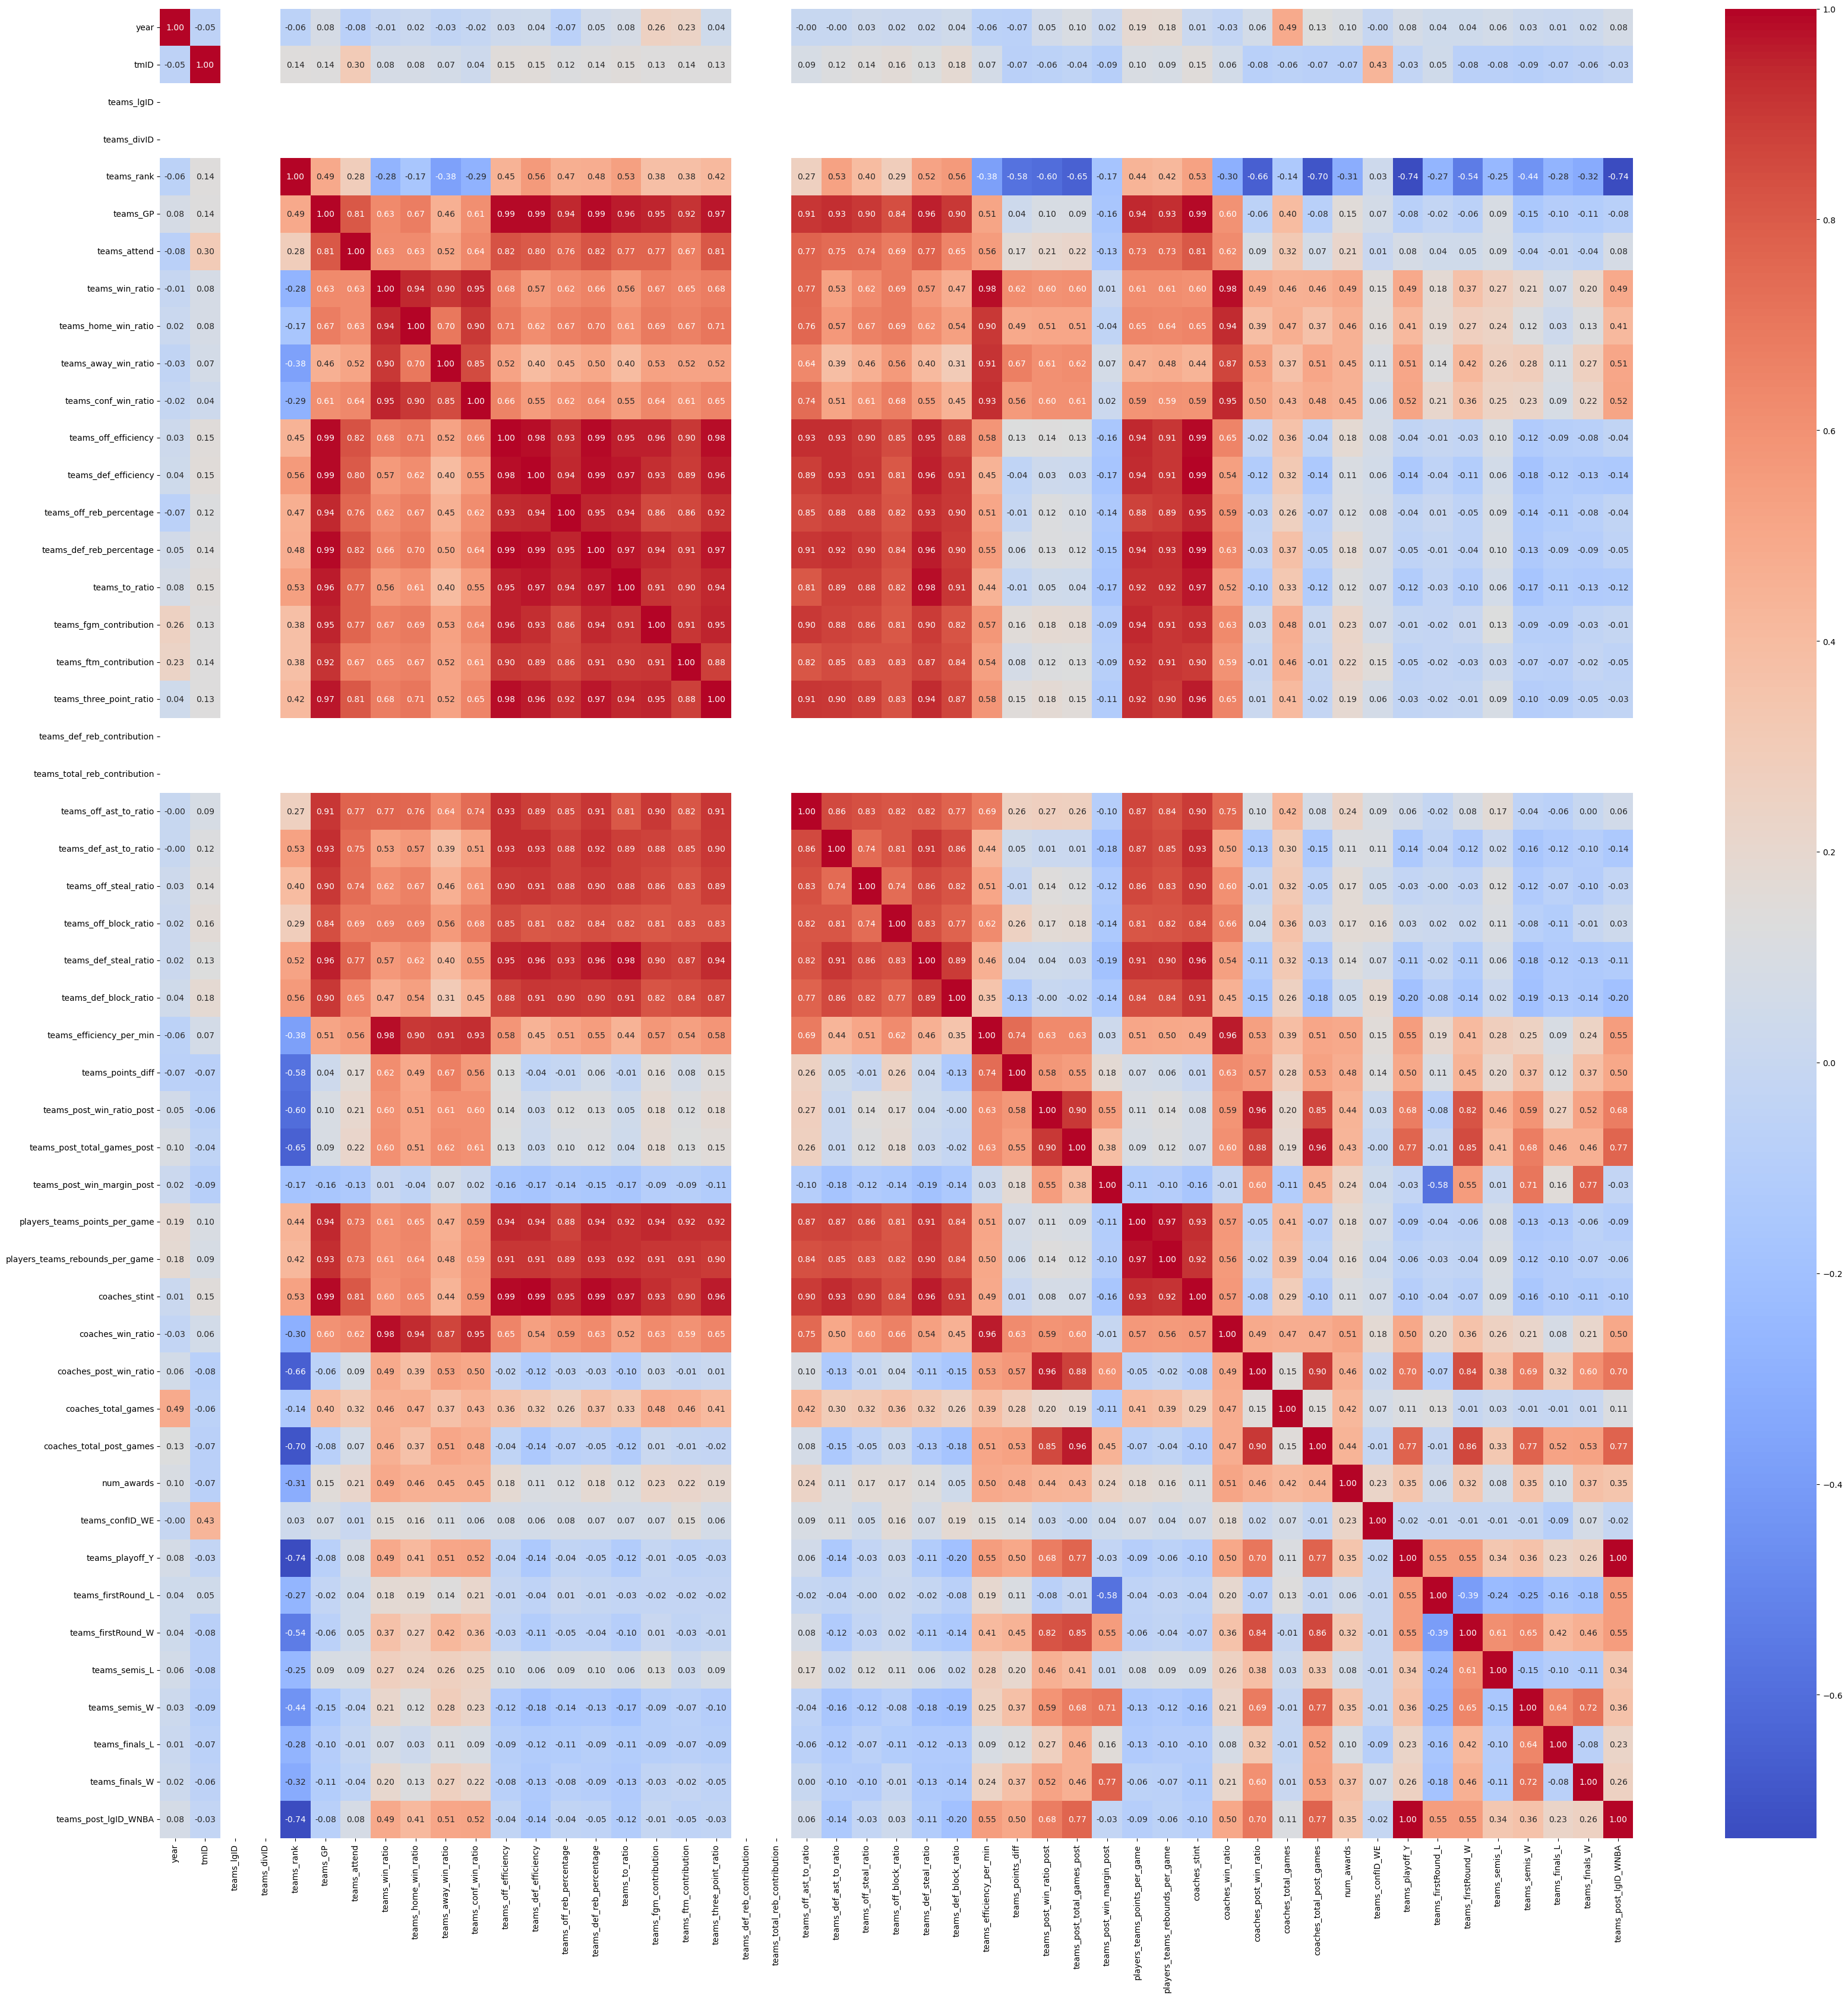

In [655]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = team_data_grouped.corr()

# Save the correlation matrix as a CSV file
corr_matrix.to_csv("correlation_matrix.csv")

# Plot heatmap for correlation
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [657]:
# Find columns with high correlation (|correlation| >= 0.75) to determine which to drop
columns_to_drop = set()

# Iterate through the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= 0.90:
            # Drop the second column in the highly correlated pair
            col2 = corr_matrix.columns[j]
            columns_to_drop.add(col2)

# Create a reduced dataframe by dropping these columns
reduced_data = team_data_grouped.drop(columns=list(columns_to_drop))

# Generate new interaction terms for remaining columns
# Select numerical columns for interaction term creation
remaining_numerical_columns = reduced_data.select_dtypes(include=[np.number]).columns

print(columns_to_drop)


{'teams_away_win_ratio', 'players_teams_points_per_game', 'teams_off_reb_percentage', 'teams_three_point_ratio', 'teams_efficiency_per_min', 'coaches_stint', 'teams_def_efficiency', 'teams_post_total_games_post', 'teams_ftm_contribution', 'coaches_total_post_games', 'teams_def_block_ratio', 'teams_conf_win_ratio', 'teams_off_ast_to_ratio', 'teams_off_efficiency', 'teams_to_ratio', 'teams_fgm_contribution', 'coaches_win_ratio', 'players_teams_rebounds_per_game', 'teams_def_steal_ratio', 'teams_def_reb_percentage', 'coaches_post_win_ratio', 'teams_off_steal_ratio', 'teams_def_ast_to_ratio', 'teams_home_win_ratio', 'teams_post_lgID_WNBA'}


In [659]:
reduced_data.columns

Index(['year', 'tmID', 'teams_lgID', 'teams_divID', 'teams_rank', 'teams_GP',
       'teams_attend', 'teams_win_ratio', 'teams_def_reb_contribution',
       'teams_total_reb_contribution', 'teams_off_block_ratio',
       'teams_points_diff', 'teams_post_win_ratio_post',
       'teams_post_win_margin_post', 'coaches_total_games', 'num_awards',
       'teams_confID_WE', 'teams_playoff_Y', 'teams_firstRound_L',
       'teams_firstRound_W', 'teams_semis_L', 'teams_semis_W',
       'teams_finals_L', 'teams_finals_W'],
      dtype='object')

In [715]:
# Step 1: Sort the data by team ID and year
reduced_data_sorted = reduced_data.sort_values(by=['tmID', 'year'])

# Step 2: Shift the `teams_playoff_Y` column by -1 year within each team group
reduced_data_sorted['next_season_playoff'] = reduced_data_sorted.groupby('tmID')['teams_playoff_Y'].shift(-1)

# Sort data by `year` and `tmID`
reduced_data_sorted['next_season_playoff'].fillna(0, inplace=True)

# Initialize an empty list to store predictions and corresponding years
all_predictions = []
all_actuals = []

# List of years in the dataset
years = reduced_data_sorted['year'].unique()

C:\Users\nakaj\AppData\Local\Temp\ipykernel_23772\316196844.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reduced_data_sorted['next_season_playoff'].fillna(0, inplace=True)


In [753]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier, DMatrix, train as xgb_train
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Initialize lists to store overall predictions and actuals
all_predictions = []
all_actuals = []

# Sort years in ascending order
years = reduced_data_sorted['year'].unique()
years.sort()

# Number of epochs
epochs = 10

# Initialize the model once outside the loops
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    reg_alpha=1.0,        # Increased L1 regularization term on weights
    reg_lambda=1.0,       # Increased L2 regularization term on weights
    learning_rate=0.05,   # Reduced learning rate
    max_depth=3,          # Reduced tree depth
    min_child_weight=5,   # Increased minimum sum of instance weight (hessian) needed in a child
    subsample=0.8,        # Subsample ratio of the training instances
    colsample_bytree=0.8  # Subsample ratio of columns when constructing each tree
)

# Initialize empty DataFrames to accumulate training data
X_cumulative = pd.DataFrame()
y_cumulative = pd.Series(dtype=int)

# Placeholder for the previous model
prev_model = None

# Total number of boosting rounds added so far
total_boosting_rounds = 0
max_total_boosting_rounds = 1000  # Maximum total number of trees allowed

# Rolling training and prediction loop for multiple epochs
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_predictions = []
    epoch_actuals = []

    # Adjust learning rate over epochs (learning rate schedule)
    current_learning_rate = clf.get_params()['learning_rate'] * (0.5 ** epoch)
    clf.set_params(learning_rate=current_learning_rate)

    for i in range(len(years) - 1):  # Exclude the last year for testing
        # Define the training years and testing year
        train_years = years[:i+1]  # Accumulate data up to the current year
        test_year = years[i + 1]

        # Split data into training and testing sets based on years
        train_data = reduced_data_sorted[reduced_data_sorted['year'].isin(train_years)]
        test_data = reduced_data_sorted[reduced_data_sorted['year'] == test_year]

        # Define X and y for training and testing
        X_train = train_data.drop(columns=['next_season_playoff', 'year', 'tmID'])
        y_train = train_data['next_season_playoff'].astype(int)
        X_test = test_data.drop(columns=['next_season_playoff', 'year', 'tmID'])
        y_test = test_data['next_season_playoff'].astype(int)

        # Identify postseason columns and drop them to prevent data leakage
        postseason_columns = [col for col in X_train.columns if 'post' in col.lower()]
        X_train = X_train.drop(columns=postseason_columns)
        X_test = X_test.drop(columns=postseason_columns)

        # Reset index to avoid alignment issues
        X_train.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)

        # Accumulate training data
        X_cumulative = pd.concat([X_cumulative, X_train], ignore_index=True)
        y_cumulative = pd.concat([y_cumulative, y_train], ignore_index=True)

        # Handle class imbalance by adjusting scale_pos_weight
        class_counts = y_cumulative.value_counts()
        if len(class_counts) > 1 and class_counts[1] > 0:
            scale_pos_weight = class_counts[0] / class_counts[1]
        else:
            scale_pos_weight = 1

        # Update the model's parameters
        clf.set_params(scale_pos_weight=scale_pos_weight)

        # Convert data to DMatrix
        dtrain = DMatrix(data=X_cumulative, label=y_cumulative)
        dtest = DMatrix(data=X_test)

        # Set training parameters
        params = clf.get_xgb_params()
        params['scale_pos_weight'] = scale_pos_weight
        params['learning_rate'] = current_learning_rate

        # Prepare evaluation set for early stopping
        val_size = min(1000, int(0.1 * len(X_cumulative)))  # Use 10% of data or up to 1000 samples
        if val_size >= 10:
            X_val = X_cumulative.iloc[-val_size:]
            y_val = y_cumulative.iloc[-val_size:]
            dval = DMatrix(data=X_val, label=y_val)
            evals = [(dtrain, 'train'), (dval, 'validation')]
            early_stopping_rounds = 5
        else:
            evals = [(dtrain, 'train')]
            early_stopping_rounds = None

        # Limit the number of boosting rounds
        remaining_boosting_rounds = max(0, max_total_boosting_rounds - total_boosting_rounds)
        num_boost_round = min(10, remaining_boosting_rounds)
        if num_boost_round == 0:
            print("Maximum number of trees reached. Skipping further training.")
            break  # Exit the loop or continue without training

        total_boosting_rounds += num_boost_round

        # Train the model incrementally
        bst = xgb_train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            xgb_model=prev_model,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )

        # Save the model for next iteration
        prev_model = bst

        # Make predictions on the test data
        y_pred_proba = bst.predict(dtest)
        y_pred = (y_pred_proba >= 0.5).astype(int)

        # Store the predictions and actuals for overall evaluation
        all_predictions.extend(y_pred)
        all_actuals.extend(y_test)
        epoch_predictions.extend(y_pred)
        epoch_actuals.extend(y_test)

        # Compute metrics for the current year
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        try:
            auc_score = roc_auc_score(y_test, y_pred_proba)
        except ValueError:
            auc_score = np.nan

        # Print metrics for the current year
        print(f"Year {train_years[-1]} -> Year {test_year} | "
              f"Accuracy: {accuracy:.2f} | F1-Score: {f1:.2f} | "
              f"AUC: {auc_score if not np.isnan(auc_score) else 'N/A'}")

    # Compute and print metrics for the current epoch
    if len(epoch_actuals) == 0:
        print(f"Epoch {epoch + 1} Summary | No predictions made.")
    else:
        epoch_accuracy = accuracy_score(epoch_actuals, epoch_predictions)
        epoch_f1 = f1_score(epoch_actuals, epoch_predictions, zero_division=0)
        try:
            epoch_auc = roc_auc_score(epoch_actuals, [1 if pred == 1 else 0 for pred in epoch_predictions])
        except ValueError:
            epoch_auc = np.nan

        print(f"Epoch {epoch + 1} Summary | "
              f"Accuracy: {epoch_accuracy:.2f} | F1-Score: {epoch_f1:.2f} | "
              f"AUC: {epoch_auc if not np.isnan(epoch_auc) else 'N/A'}")
        print(f"Total Boosting Rounds So Far: {total_boosting_rounds}")

    # Check if maximum number of trees has been reached
    if total_boosting_rounds >= max_total_boosting_rounds:
        print("Reached maximum total boosting rounds. Ending training.")
        break  # Exit the epochs loop

# Calculate overall metrics across all epochs and years
if len(all_actuals) == 0:
    print("No predictions were made during training.")
else:
    overall_accuracy = accuracy_score(all_actuals, all_predictions)
    overall_f1 = f1_score(all_actuals, all_predictions, zero_division=0)
    try:
        overall_auc = roc_auc_score(all_actuals, [1 if pred == 1 else 0 for pred in all_predictions])
    except ValueError:
        overall_auc = np.nan

    print(f"\nOverall Prediction Metrics | "
          f"Accuracy: {overall_accuracy:.2f} | F1-Score: {overall_f1:.2f} | "
          f"AUC: {overall_auc if not np.isnan(overall_auc) else 'N/A'}")



Epoch 1/10
Year 1 -> Year 2 | Accuracy: 0.50 | F1-Score: 0.67 | AUC: 0.5
Year 2 -> Year 3 | Accuracy: 0.50 | F1-Score: 0.43 | AUC: 0.4920634920634921
Year 3 -> Year 4 | Accuracy: 0.50 | F1-Score: 0.46 | AUC: 0.6875
Year 4 -> Year 5 | Accuracy: 0.62 | F1-Score: 0.55 | AUC: 0.75
Year 5 -> Year 6 | Accuracy: 0.62 | F1-Score: 0.62 | AUC: 0.825
Year 6 -> Year 7 | Accuracy: 0.36 | F1-Score: 0.40 | AUC: 0.5208333333333334
Year 7 -> Year 8 | Accuracy: 0.46 | F1-Score: 0.46 | AUC: 0.325
Year 8 -> Year 9 | Accuracy: 0.43 | F1-Score: 0.43 | AUC: 0.625
Year 9 -> Year 10 | Accuracy: 0.54 | F1-Score: 0.00 | AUC: N/A
Epoch 1 Summary | Accuracy: 0.50 | F1-Score: 0.49 | AUC: 0.5
Total Boosting Rounds So Far: 90

Epoch 2/10
Year 1 -> Year 2 | Accuracy: 0.94 | F1-Score: 0.93 | AUC: 0.96875
Year 2 -> Year 3 | Accuracy: 0.88 | F1-Score: 0.86 | AUC: 0.9365079365079365
Year 3 -> Year 4 | Accuracy: 0.86 | F1-Score: 0.88 | AUC: 0.8958333333333334
Year 4 -> Year 5 | Accuracy: 0.85 | F1-Score: 0.86 | AUC: 0.925

In [721]:
X_train, X_test, y_train, y_test = train_test_split(reduced_data_sorted.drop(columns=['next_season_playoff','year','tmID']), reduced_data_sorted['next_season_playoff'].astype(int), test_size=0.2, random_state=42)

In [727]:


# Create the decision tree classifier
clf = DecisionTreeClassifier(random_state=100, min_samples_split=10, min_samples_leaf=5)

# Train the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=10,
                       random_state=100)

In [729]:
# Create and train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 0.46153846153846156
              precision    recall  f1-score   support

           0       1.00      0.46      0.63        13
           1       0.00      0.00      0.00         0

    accuracy                           0.46        13
   macro avg       0.50      0.23      0.32        13
weighted avg       1.00      0.46      0.63        13



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true 

In [669]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 0.5862068965517241
              precision    recall  f1-score   support

           0       0.64      0.47      0.54        15
           1       0.56      0.71      0.62        14

    accuracy                           0.59        29
   macro avg       0.60      0.59      0.58        29
weighted avg       0.60      0.59      0.58        29



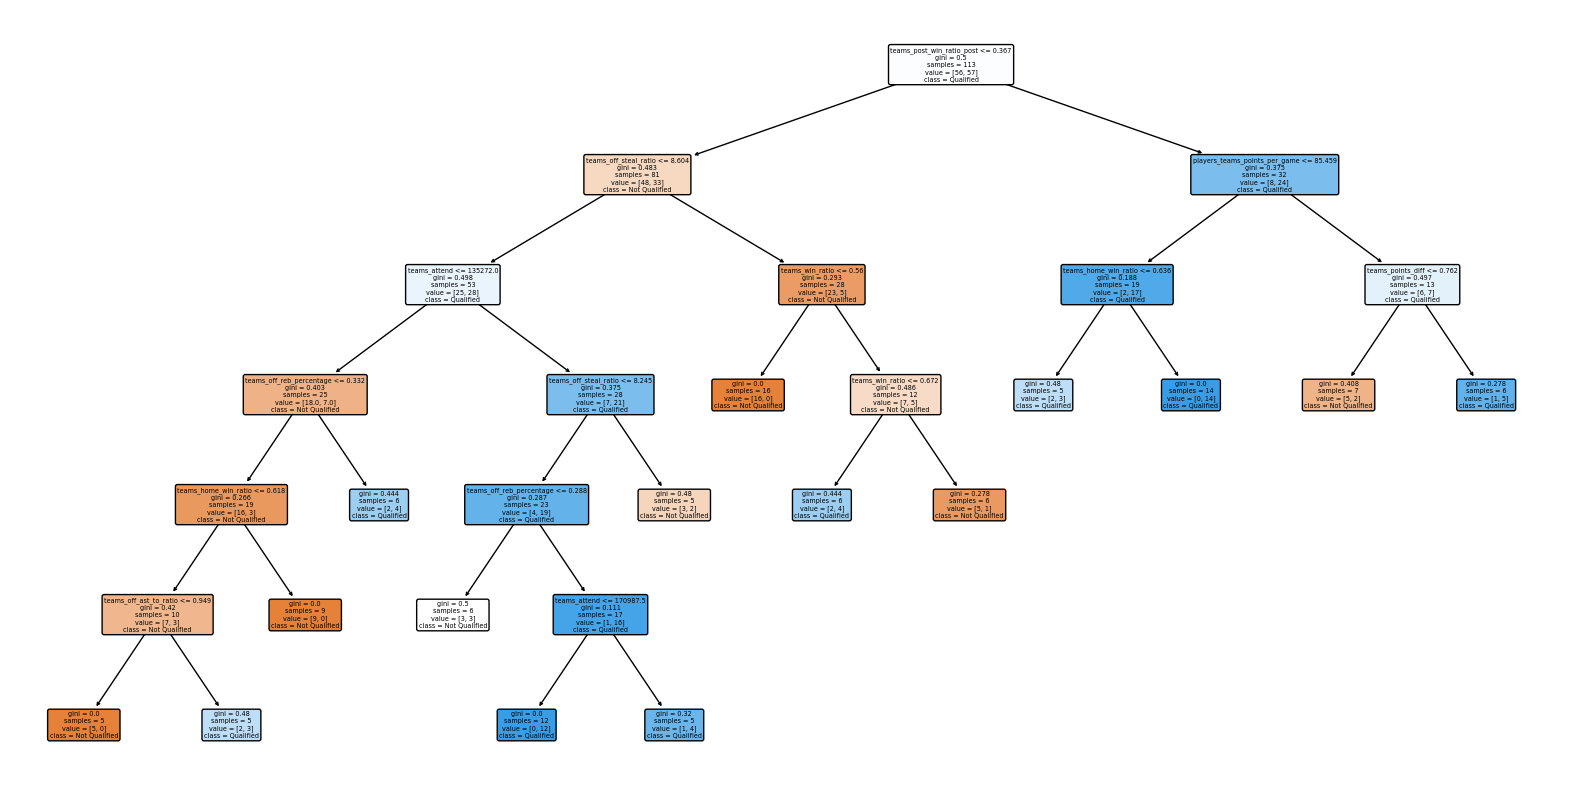

In [671]:
# Plot the decision tree using matplotlib
plt.figure(figsize=(20,10))
tree.plot_tree(clf, feature_names=X_train.columns, class_names=['Not Qualified', 'Qualified'], filled=True, rounded=True)
plt.show()


In [673]:
# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Feature importance for Random Forests
rf_feature_importances = pd.DataFrame(rf_clf.feature_importances_,
                                      index=X_train.columns,
                                      columns=['importance']).sort_values('importance', ascending=False)

In [675]:
y_pred = rf_clf.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

print(rf_feature_importances)

Accuracy: 0.4827586206896552
              precision    recall  f1-score   support

           0       0.50      0.47      0.48        15
           1       0.47      0.50      0.48        14

    accuracy                           0.48        29
   macro avg       0.48      0.48      0.48        29
weighted avg       0.48      0.48      0.48        29

                               importance
teams_attend                     0.098955
teams_off_steal_ratio            0.085417
teams_def_block_ratio            0.078456
teams_off_reb_percentage         0.077462
teams_points_diff                0.063960
teams_def_ast_to_ratio           0.058573
players_teams_points_per_game    0.058257
teams_off_ast_to_ratio           0.057535
teams_ftm_contribution           0.054928
teams_off_block_ratio            0.049170
teams_win_ratio                  0.042613
teams_home_win_ratio             0.040467
teams_away_win_ratio             0.037589
teams_post_win_ratio_post        0.034114
teams_rank    

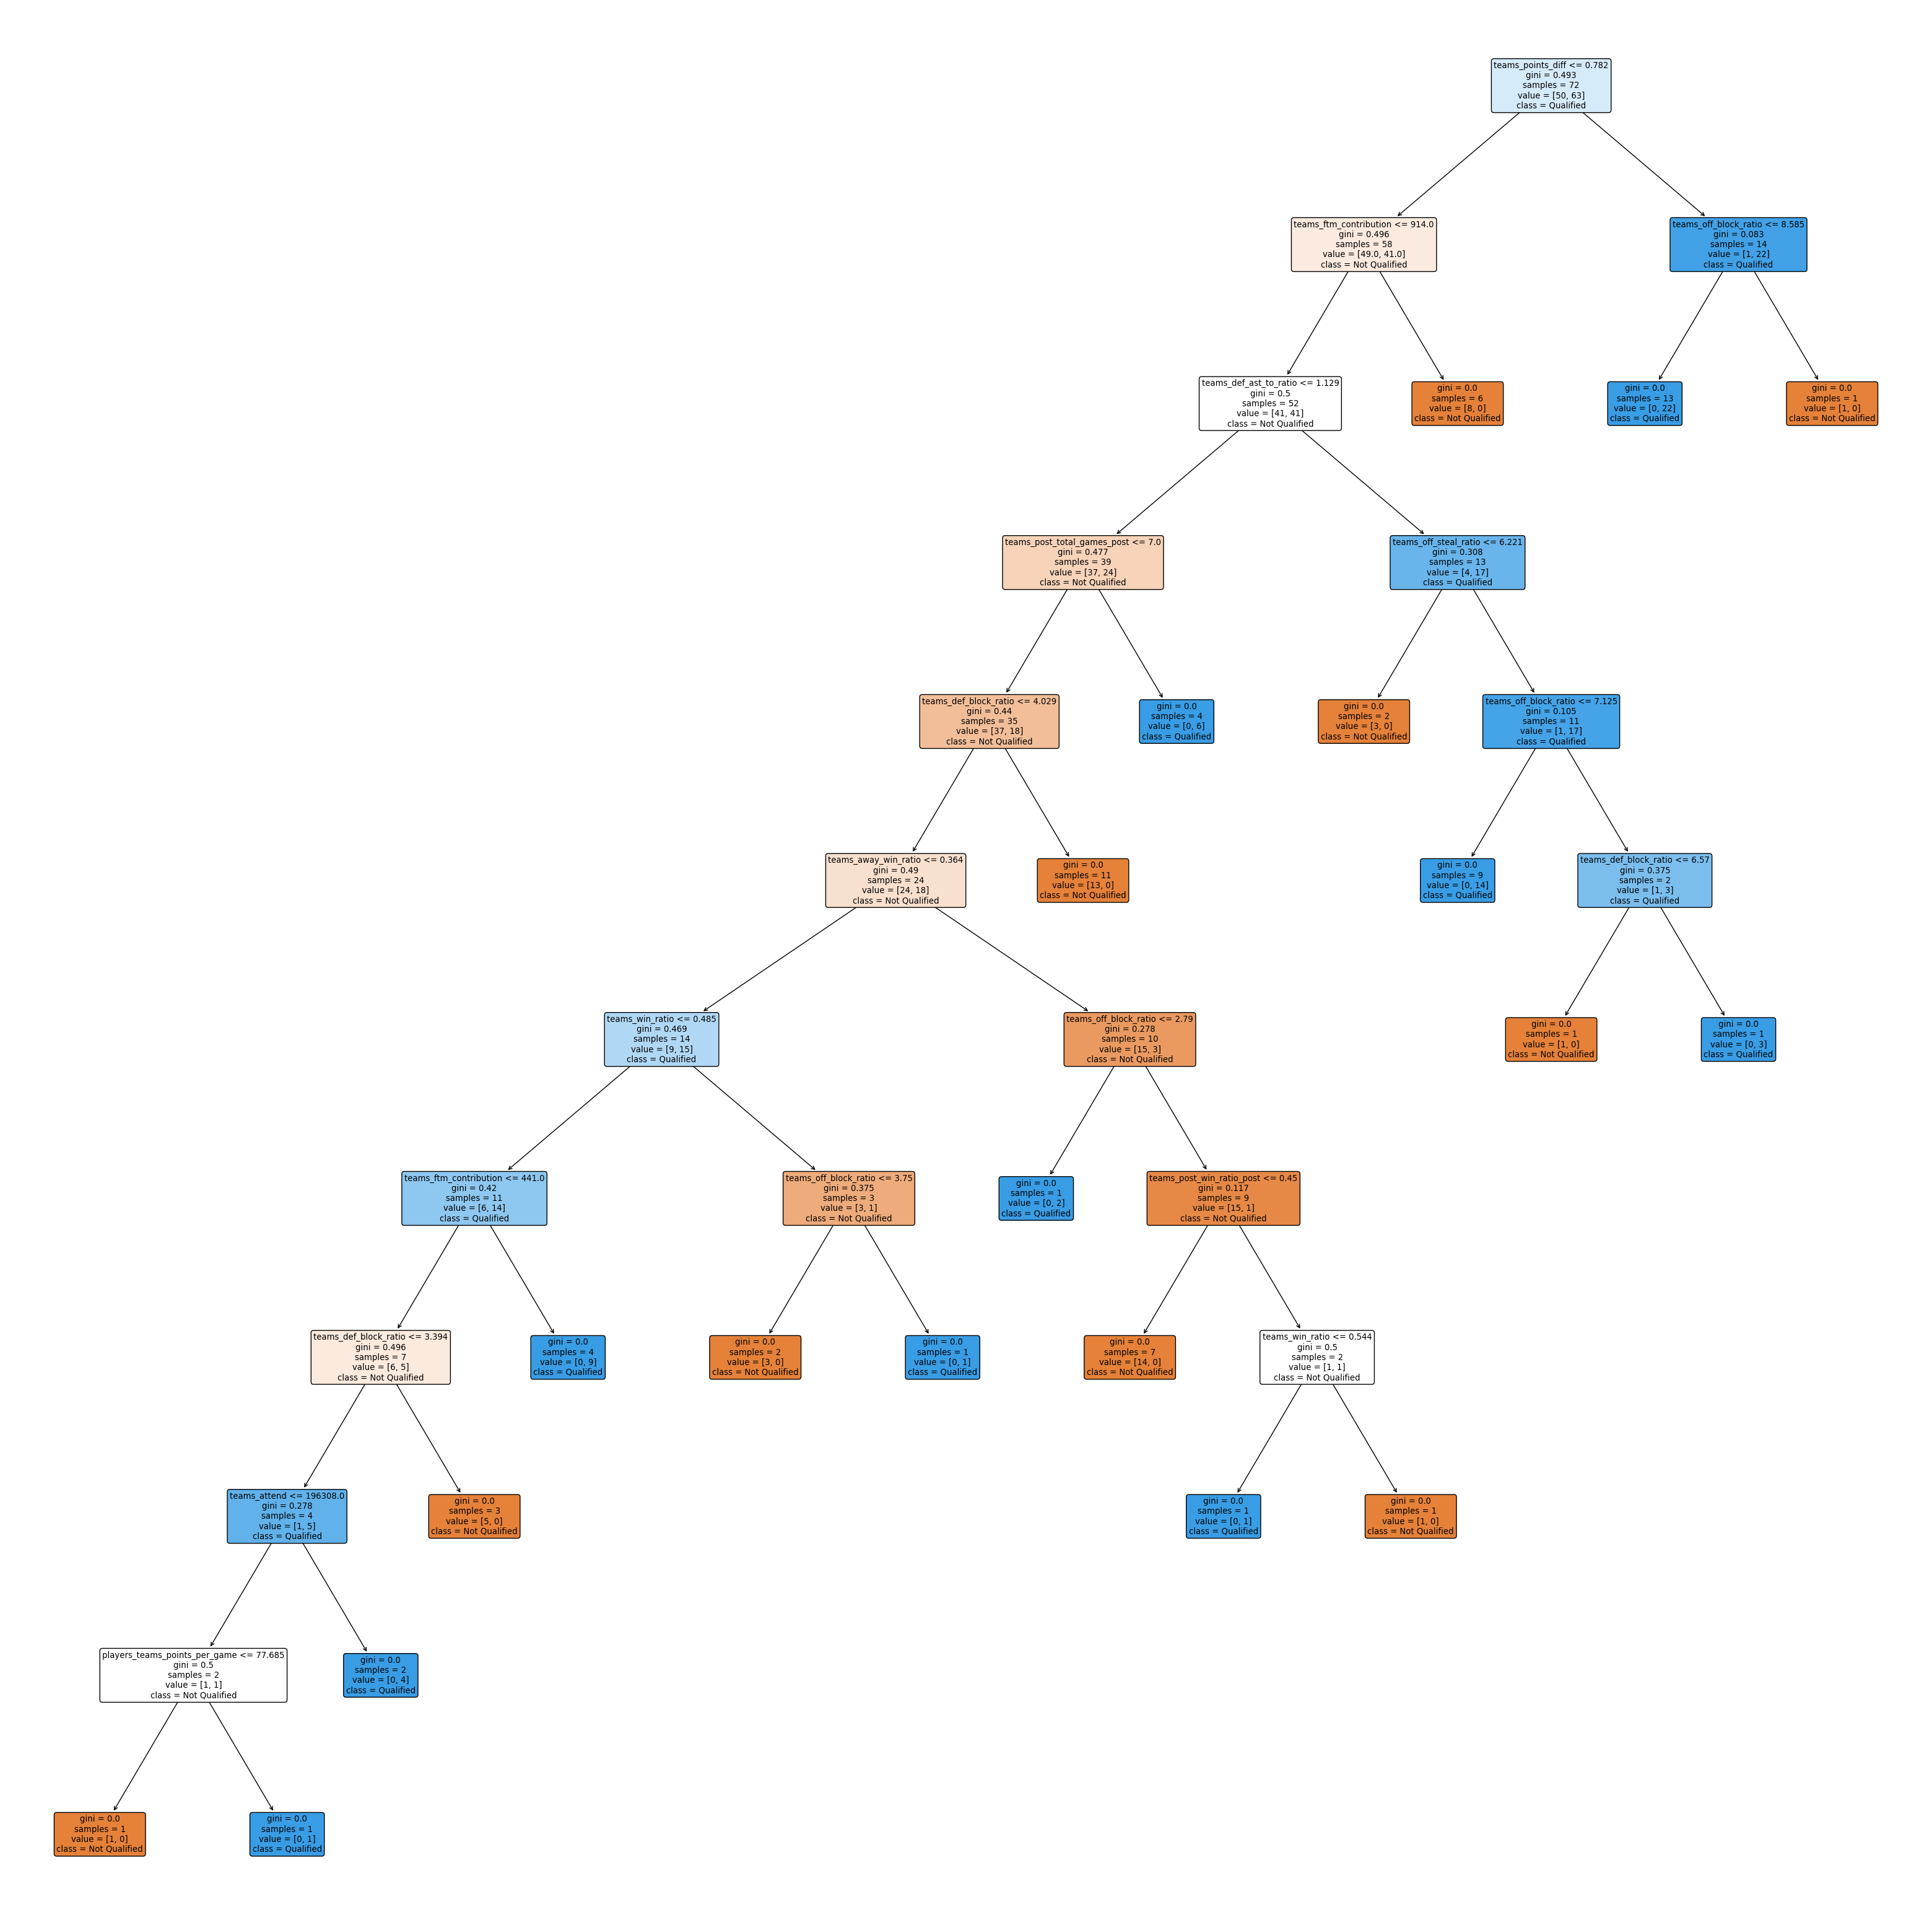

In [679]:
import matplotlib.pyplot as plt
from sklearn import tree
# Extract a single tree from the Random Forest (e.g., the first tree)
single_tree = rf_clf.estimators_[0]

# Plot the single decision tree from the random forest
plt.figure(figsize=(40, 40))
tree.plot_tree(single_tree, feature_names=X_train.columns, class_names=['Not Qualified', 'Qualified'], filled=True, rounded=True)
plt.show()


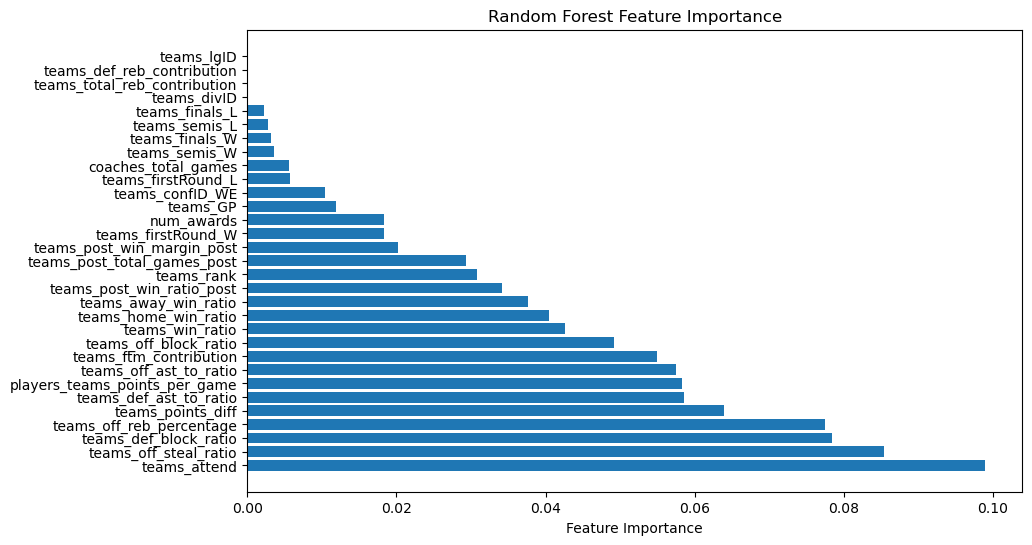

In [681]:
# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(rf_feature_importances.index, rf_feature_importances['importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()


In [685]:
# Check feature importance
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)


                               importance
teams_attend                     0.184417
teams_off_steal_ratio            0.180064
teams_post_win_ratio_post        0.162321
teams_off_reb_percentage         0.123209
teams_win_ratio                  0.116996
teams_home_win_ratio             0.061244
players_teams_points_per_game    0.059072
teams_points_diff                0.058415
teams_off_ast_to_ratio           0.054263
coaches_total_games              0.000000
num_awards                       0.000000
teams_lgID                       0.000000
teams_confID_WE                  0.000000
teams_firstRound_L               0.000000
teams_post_win_margin_post       0.000000
teams_semis_L                    0.000000
teams_semis_W                    0.000000
teams_finals_L                   0.000000
teams_firstRound_W               0.000000
teams_off_block_ratio            0.000000
teams_post_total_games_post      0.000000
teams_def_block_ratio            0.000000
teams_divID                      0

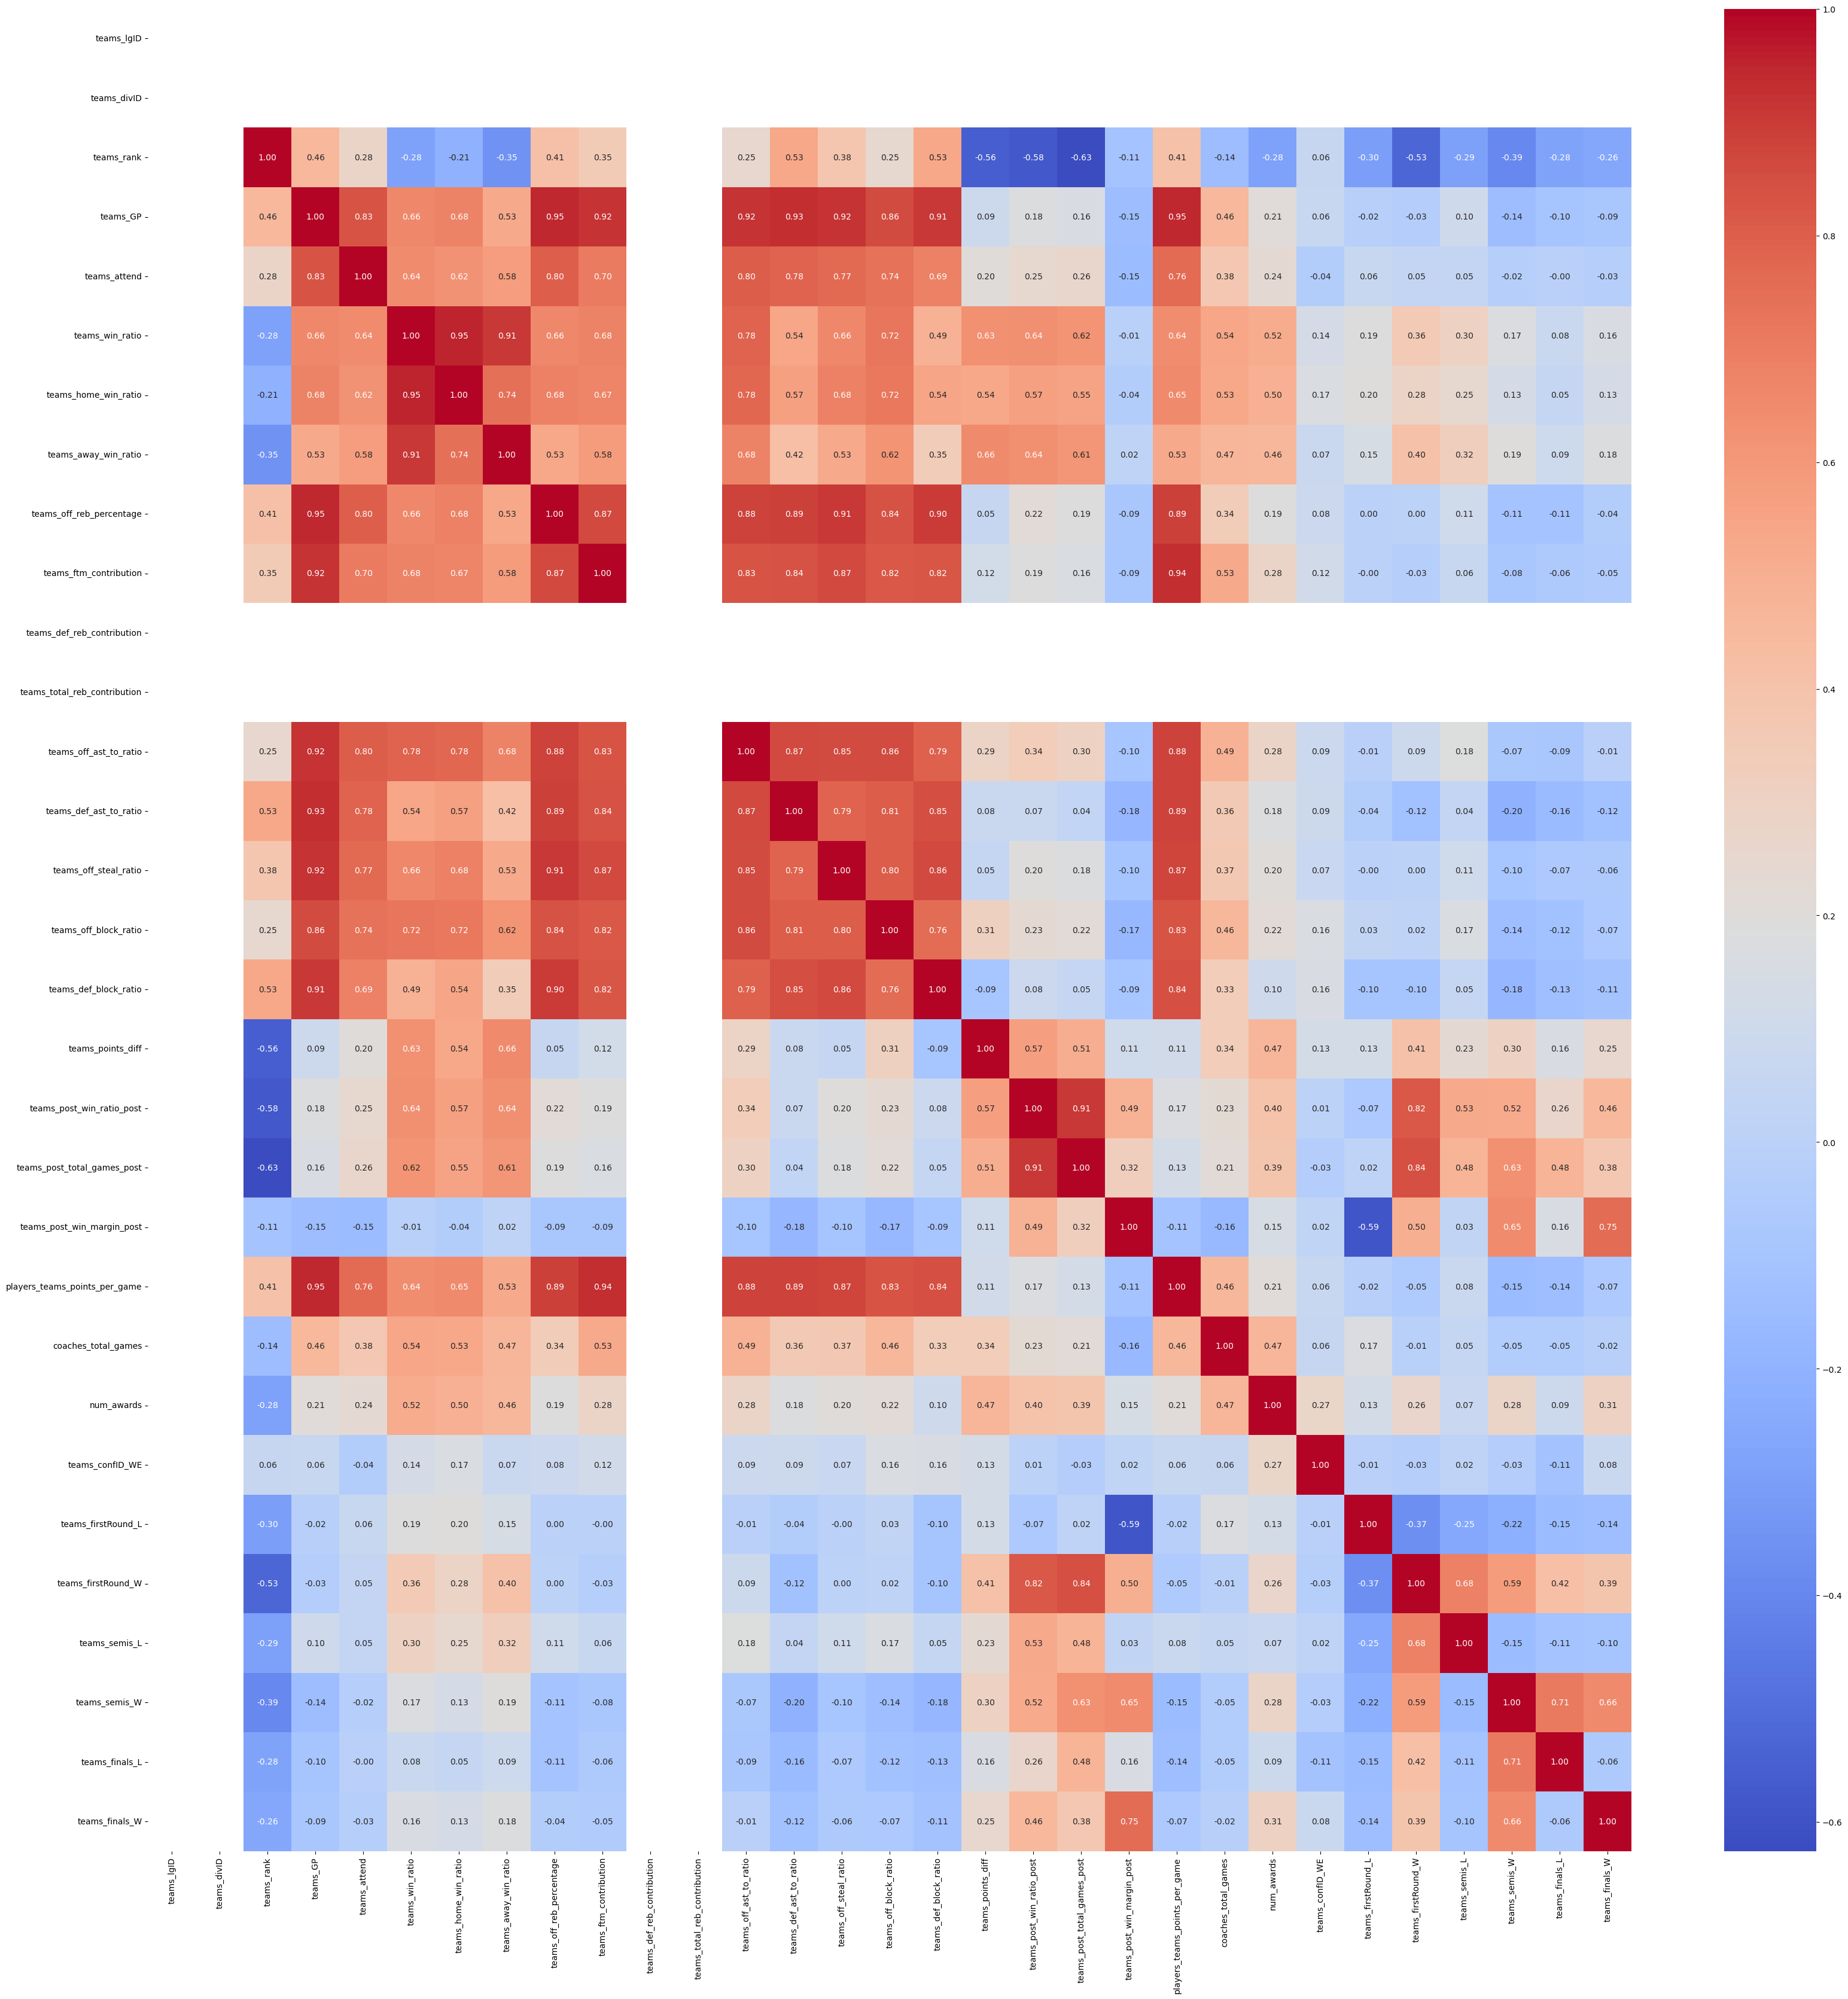

In [689]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = X_train.corr()

# Plot heatmap for correlation
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [691]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [701]:
# Example: Increase the complexity of the model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\nakaj\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [703]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train_scaled, y_train, epochs=300, batch_size=16, validation_data=(X_test_scaled, y_test))


Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.5498 - loss: 0.6887 - val_accuracy: 0.6207 - val_loss: 0.6820
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5534 - loss: 0.6641 - val_accuracy: 0.6552 - val_loss: 0.6790
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5952 - loss: 0.6389 - val_accuracy: 0.6552 - val_loss: 0.6795
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6000 - loss: 0.6406 - val_accuracy: 0.6897 - val_loss: 0.6802
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6324 - loss: 0.6167 - val_accuracy: 0.7241 - val_loss: 0.6830
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6356 - loss: 0.6078 - val_accuracy: 0.6897 - val_loss: 0.6902
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6301 - loss: 0.5968 - val_accuracy: 0.6897 - val_loss: 0.6937
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6006 - loss: 0.6202 - val_accuracy: 0.7241 - val_loss:

In [705]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_accuracy}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6207 - loss: 1.6860
Test Accuracy: 0.6206896305084229


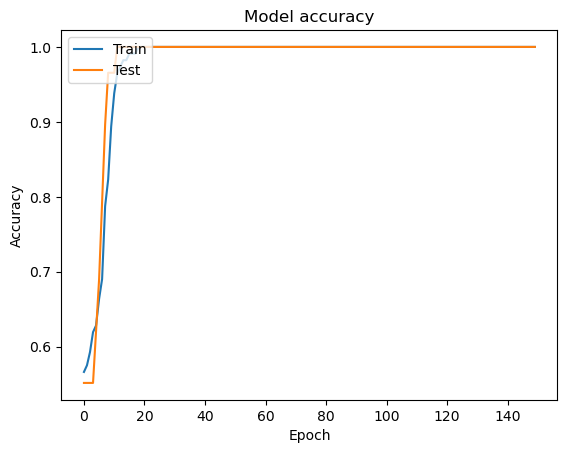

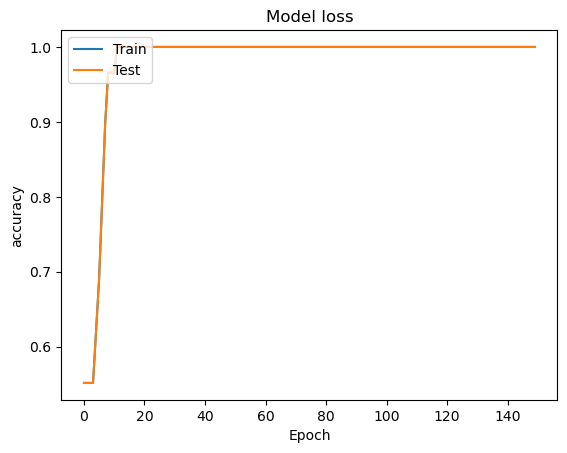

In [409]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [213]:
# Predict class labels on the test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
